<a href="https://colab.research.google.com/github/tsp00/mass/blob/master/mass_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/http://contents2.kocw.or.kr/KOCW/data/document/2020/edu1/bdu/hongseungwook1118/023.pdf

In [1]:
import numpy as np
from keras import layers,models
from sklearn import preprocessing

In [2]:
# Duflo-Zuker mass model dz10

#_______________________________________________________________________________
# dz10 parameters
b_def = np.array([0.7043, 17.7418, 16.2562, 37.5562, 53.9017, 0.4711, 2.1307, 0.0210, 40.5356, 6.0632])


#_______________________________________________________________________________
def dz10_op (Z, N):
# DZ 10 operators, returns dyda2(shape=(2,10)), 2 is for spherical/deformed

   op=np.zeros(2)
   dx=np.zeros(2)
   qx=np.zeros(2)
   os=np.zeros(2)
   oei=np.zeros(2)
   dei=np.zeros(2)
   pp=np.zeros(2)
   # c*********
   nn= np.array([N, Z])
   A = N + Z
   t = np.abs(N-Z)
   r = np.power(A, 1./3.)
   #       !s=r*r
   rc = r*(1. - 0.25*np.power(t/A, 2)) 	# !      Charge radius
   ra = (rc*rc)/r
   # c--------
   z2 = Z*(Z - 1)

   # c********                          ! beginning of main loop
   dyda= np.zeros(10)
   y=np.zeros(2)
   dyda_table= np.zeros(shape=(2,10))
   for ndef in range(2): #= 0  ndef <= 1  ndef++) {	# !      ndef=0  spherical
      noc= np.zeros(shape=(2,18))
      onp= np.zeros(shape=(2,2,9))
      y[ndef] = 0.
      ju = 4 if (ndef == 1) else 0  	# !      nucleons associated to deform.
      for kk in range(10): #(int kk = 2  kk <= 10  kk++) {
         dyda[kk] = 0.
      #}
      dyda[0] = ra * (-z2 + 0.76*np.power(z2, 2./3.))/rc 	# ! ra times of Coulomb energy
      # c--------                          ! beginning of loop over N and Z
      for j in range (2): #(int j = 0  j <= 1  j++) {
         ncum = 0
         for i in range (100): #(int i = 0  i <= 100  i++) {
            id = i+2 if (i%2 == 0) else (i + 1)*(i - 1)//4 # sub-shells (ssh) j and r filli
            if (ncum + id >= nn[j]): # {
               ie=i
               break
            ncum += id
            noc[j][i] = id 	# !     nb of nucleons in each ssh
         # c--------
         ip = ie//2 	# !     HO number (p)
         pp[j] = ip
         moc = nn[j] - ncum 	# !+id
         noc[j][ie] = moc - ju 	# !     nb of nucleons in last ssh
         noc[j][ie + 1] = ju
         oei[j] = moc + ip*(ip - 1) if (ie%2 == 0) else moc - ju              # nb of nucleons in last EI she
         dei[j] = ip*(ip + 1) + 2   if (ie%2 == 0) else (ip + 1)*(ip + 2) + 2 # size of the EI shell

         qx[j] = oei[j]*(dei[j] - oei[j] - ju)/dei[j] 	# ! n*(D-n)/D        S3(j)
         dx[j] = qx[j]*(2*oei[j] - dei[j]) 	# ! n*(D-n)*(2n-D)/D  Q
         if (ndef == 1): qx[j] /= np.sqrt(dei[j]) 	# ! scaling for deformed
         # c--------
         for i in range (ie+2): #(int i = 0  i <= ie + 1  i++) {	# ! imax-1                             ! Amplitudes
            ip = i//2
            onp[j][0][ip] += noc[j][i]/np.sqrt((ip+1.)*(ip+2.)) 	# !    for FM term
            vm= 0.5*ip if (i%2 == 0) else -1. # for spin-orbit ter
            onp[j][1][ip] += noc[j][i]*vm
         # c--------
         op[j] = 0.
         os[j] = 0.
         for ip in range ((ie + 1)//2 +1): #(int ip = 0  ip <= (ie + 1)/2  ip++) {	# !ipm                !       FM and SO terms
            pi = ip
            den = np.power((pi + 1)*(pi + 2), 3./2.)
            op[j] += onp[j][0][ip] 	# ! FM
            os[j] += onp[j][1][ip]*((1. + onp[j][0][ip])*(pi*pi) + (1. - onp[j][0][ip])*(4*pi - 5))/den 	# ! SO

         op[j] *= op[j]

      # c--------                          ! end of loop over  N and Z
      dyda[1] = op[0] + op[1] 	# !   Master term (FM): volume
      dyda[2] = -dyda[1]/ra 	# !                     surface
      dyda[1] = dyda[1] + os[0] + os[1] 	# !   FM + SO
      dyda[3] = -t*(t + 2)/(r*r) 	# !   isospin term : volume
      dyda[4] = -dyda[3]/ra 	# !                : surface
      if (ndef == 0): # {	# ! sph.
         dyda[5] = dx[0] + dx[1] 	# !   S3  volume
         dyda[6] = -dyda[5]/ra 	# !       surface
         px = np.sqrt(pp[0]) + np.sqrt(pp[1])
         dyda[7] = qx[0]*qx[1]*(np.power(2, px)) 	# !   QQ sph.
      else: # {	# ! def.
         dyda[8] = qx[0]*qx[1] 	# !   QQ deform.

      dyda[4] += t*(1 - t)/(A*np.power(ra, 3)) 	# !   "Wigner term"
      # c--------                                 !   PAIRING
      if ((N%2==1) and (Z%2==1)): dyda[9] = t/A
      if (N > Z): # {
         if ((N%2==0) and (Z%2==1)): dyda[9] = 1 - t/A
         if ((N%2==1) and (Z%2==0)): dyda[9] = 1
      else: # {
         if ((N%2==0) and (Z%2==1)): dyda[9] = 1
         if ((N%2==1) and (Z%2==0)): dyda[9] = 1 - t/A

      if ((N%2==0) and (Z%2==0)): dyda[9] = 2 - t/A

      for mss in range(10): #(int mss = 1  mss <= 10  mss++) {
         dyda_table[ndef,mss]=  dyda[mss]/ra
      # c--------                            ! end of main loop
   return dyda_table


#_______________________________________________________________________________
def dz10 (Z, N, b = b_def, verbosity = 0, opfun = dz10_op):
   dyda_table= opfun (Z, N)
   y= np.zeros(2)
   for ndef in range(2): #= 0  ndef <= 1  ndef++) {	# !      ndef=0  spherical
      for mss in range(10): #(int mss = 1  mss <= 10  mss++) {
         y[ndef] += dyda_table[ndef,mss]*b[mss]

   is_deformed = 0
   be= y[0]
   if (y[1] > y[0] and Z > 50):
      is_deformed = 1
      be= y[1]

   if verbosity <= 0 : return be
   if verbosity == 1 : return be, is_deformed

   return be, is_deformed,dyda_table[is_deformed]

In [3]:
dz10(50, 81)

1095.0984200112887

In [4]:
dz10(38,53)

787.8845069732481

In [5]:
# Duflo-Zuker mass model dz33

#_______________________________________________________________________________
# dz33 parameters
a_28=np.array([
   9.0914*2, 6.3355*2, 4.5791, 19.8946, 1.7325, 7.5247,
   -7.1953, -39.9787, -0.3976, 0.8131, -0.7435, -3.7291,
   -0.1305, -0.6387, 0.4534, 2.0605, 0.3449, 1.4727,
   -1.0433, 0.0000, 5.2495, 0.0000, -32.1007, -151.1164,
   -4.6103, -32.4238, 37.3226*4, 52.1673*4, 0.9597, 3.0024,
   0.6977, 6.0390, 17.7960 ])

a_fit_1=np.array([
    18.3823114678441, 14.9654647147403, 5.16043547913969, 23.6791652365813, 1.69198437698102, 7.70752795386154,          # FM+, FS+, FS-
    -4.89968997566140, -41.9546818849829, -0.452541072665594, -0.115672475977305, -0.841966943307345, -4.26430263634212, # FC+, PM+, PS+
    -0.106021683952664, -0.562161540801153, 0.427309092386025, 1.96420799950015, 0.334218482733298, 1.31955010861289,    # PS-, S3,  SQ-
    -8.103099200805119/100, 8.20516288043133, 6.14976974664344, 5.32159824150776, -33.1968387296639, -158.618534804942,  # D3,  QQ+, D0
    -2.77690717089939, -24.5189516535313, 149.743976383871, 209.350547986690, 1.15196960067461, 3.72823843532976,        # QQ-, asym,SS
    0.702321263796662, 6.19508179596490, 9.74100193880679])                                                              # EC,  P1,  P2

a_fit_2=np.array([
    18.3221122504656, 14.5224438086702, 5.38508401938650, 24.8228141400897, 1.74698778464929, 7.91311926171185,
    -5.48565655334926, -42.8968460273137, -0.435917749563838, 3.908547722336988/100, -0.872068966794544, -4.42502282169325,
    -0.127419381208396, -0.668296738146491, 0.435870298399898, 2.00690509793684, 0.345745626292599, 1.40096007168900,
    1.28594442409618, 16.2884201477635, 5.79492771834656, 1.73923193482831, -33.4964972193808, -159.670174045318,
    -2.03517005308097, -18.7256526429027, 149.992913856565, 210.699329582436, 1.22681220517222, 4.06350605475340,
    0.701672917012658, 6.25922079319403, 8.99509716404338])

a_fit_3=np.array([
    18.6228397521178, 15.8127576459535, 3.41694534980079, 14.5804580920230, 1.35692505906094, 6.41683661357447,
    -1.94788844902597, -28.5255998068208, -0.644332680103499, -0.819341338674875, -0.535341673865479, -2.55311797652534,
    -0.136146129695100, -0.694037733724995, 0.455186789743238, 2.04846967472275, 0.338773739280799, 1.33999676626953,
    8.12815311636854, 50.3506134798718, -1.82915100886547, -39.8136431369429, -23.4674927512946, -108.181314678997,
    12.8175343210966, 65.0038503245761, 149.285763376006, 207.179983732669, 1.50059967529012, 4.31016747430967,
    0.701272742023415, 6.19590396338389, 8.07882516556805])


#_______________________________________________________________________________
# dz33 operators
def dz33_op (nz, nx):
   dyda= np.zeros(33)
   dyda_table= np.zeros(shape=(2,33))
   #    !C*****************************************
   #    !      data a/ 9.0914,   6.3355,   4.5791,  19.8946,   1.7325,   7.5247,
   #    !     &       -7.1953, -39.9787,  -0.3976,   0.8131,  -0.7435,  -3.7291,
   #    !     &       -0.1305,  -0.6387,   0.4534,   2.0605,   0.3449,   1.4727,
   #    !     &       -1.0433,   0.0000,   5.2495,   0.0000, -32.1007,-151.1164,
   #    !     &       -4.6103, -32.4238, -37.3226, -52.1673,   0.9597,   3.0024,
   #    !     &        0.6977,   6.0390,  17.7960/
   #    ! Data=1751 RMS= 0.330  (mars 95)
   #    !FM+*   9.09 fm+*   6.34 FS+*   4.58 fs+*  19.89 FS-*   1.73 fs-*   7.52
   #    !FC+*  -7.20 fc+* -39.98 PM+*  -0.40 pm+*   0.81 PS+*  -0.74 ps+*  -3.73
   #    !PS-*  -0.13 ps-*  -0.64 S3 *   0.45 s3 *   2.06 SQ-*   0.34 sq-*   1.47
   #    !D3 *  -1.04 d3     0.00 QQ+*   5.25 qq+    0.00  D0* -32.10  d0*-151.12
   #    !QQ-*  -4.61 qq-* -32.42  TT* -37.32  tt* -52.17  SS*   0.96  ss*   3.00
   #    ! C *   0.70 P0 *   6.04 P1 *  17.80
   #    !                    ----------------------
   #    ! 31 Coulomb
   #    ! 32+33 Pairing
   #    !
   imax = 18
   mo = 2
   maxp = 8
   nn= np.array([nx,nz])
   v = nx + nz
   t = np.abs(nx-nz)
   r = np.power(v, 1./3.)
   s = r*r
   rc = r*(1. - 0.25*np.power(t/v, 2))
   ra = (rc*rc)/r
   #    !******************
   for ndef in range(2): # ndef= 0->SPH# 1->DEF#
      jup= np.zeros(2)
      jud= np.zeros(2)
      #       !-----------
      ju= 4 if (ndef == 1 and nz > 50) else 0
      fyda= np.zeros(33)
      fyd0= np.zeros(33)
      dyda= np.zeros(33)

      noc= np.zeros(shape=(2,imax))
      onp= np.zeros(shape=(2,mo,maxp+1))
      ot= np.zeros(shape=(2,mo,maxp+1))

      onps= np.zeros(2)
      oei= np.zeros(2)
      dei= np.zeros(2)
      sshell= np.zeros(2)

      for j in range(2):
         ncum = 0
         for i1 in range(999+1):
            i = i1 + 1
            ie = i
            if (i%2 != 0):
               id = i + 1
               if (ncum < nn[j]): sshell[j] = 1.	# ! !sscouche  J
            else:
               id = i*(i - 2)/4
               if (ncum < nn[j]): sshell[j] = 2.	# ! ! SSC R

            ncum += id
            if (ncum > nn[j]): break
            noc[j][i1] = id

         i = ie
         ip = (i-1)//2	# ! !N0 couche HO
         moc = nn[j] - ncum + id
         if ((ndef == 1) and (i%2 != 0)):
            jud[j] = max(0, ju-moc)
            jup[j] = 0
         else:
            jup[j] = min(ju, moc)
            jup[j] = ju
            jud[j] = 0

         noc[j][i-1] = moc - jup[j] + jud[j]
         noc[j][i] = jup[j]
         noc[j][i - 2] -= jud[j]
         if (i%2 != 0):
            oei[j] = moc + ip*(ip - 1) - ju
            dei[j] = ip*(ip + 1) + 2
         else:
            oei[j] = moc - ju
            dei[j] = (ip + 1)*(ip + 2) + 2

         #          !C HERE,DEGENERACIES AND NUMBER OF ACTIVE PARTICLES  FOR  EI.
         ipl = 0
         vmr = 0.
         vmj = 0.
         for ii in range(imax):
            onps[j] = 0.
            ip = (ii)//2
            degi = (ip + 1)*(ip + 2)
            fac = 1./np.sqrt(degi)
            if (ip != ipl): ipl= ipl+1
            if ((2*ip + 1) == ii+1):
               vm2 = (0.5*ip)/(ip + 1)
               degr = ip*(ip - 1)
               if (ip > 2):
                  vmr = (0.5*(ip - 1))/ip
                  vmj = -1./ip
                  if (noc[j][ii] <= degr): onps[j] = noc[j][ii]*vmr
                  if (noc[j][ii] > degr): onps[j] = degr*vmr + (noc[j][ii] - degr)*vmj

            if ((2*ip + 1) != ii+1): vm2 = -1./(ip + 1)	# ! !SSc. j
            onp[j][1][ipl] += noc[j][ii]*vm2
            onp[j][0][ipl] += noc[j][ii]*fac
            fyd0[28] += onps[j]*(onp[j][0][ipl] + onp[j][1][ipl])

      # ! !END OF LOOP OVER FLUIDS, j
      if (ndef == 1):
         alfa = 0.
      else:
         alfa = 0.5

      facn = np.power(dei[0], alfa)
      facz = np.power(dei[1], alfa)
      dnnb = oei[0]*(dei[0] - oei[0])/dei[0]
      dzzb = oei[1]*(dei[1] - oei[1])/dei[1]
      qn = dnnb*facn/np.sqrt(dei[0])
      qz = dzzb*facz/np.sqrt(dei[1])
      di1n = dnnb*(2*oei[0] - dei[0])*facn*facn/(dei[0])
      di1z = dzzb*(2*oei[1] - dei[1])*facz*facz/(dei[1])
      s3 = di1z + di1n
      qq0 = (qn + qz)*(qn + qz)
      qq1 = (qn - qz)*(qn - qz)
      qqp = qq0 + qq1
      qqm = qq0 - qq1
      for m in range(mo):
         for i in range(maxp+1):
            ot[0][m][i] = onp[0][m][i] + onp[1][m][i]
            ot[1][m][i] = onp[0][m][i] - onp[1][m][i]

      op= np.zeros(shape=(2,3,2))
      op1= np.zeros(2)
      op2= np.zeros(2)

      for i in range(maxp+1):
         degi = (i + 1)*(i + 2)
         fac = np.sqrt(degi)
         for j in range(2):
            for m in range(mo):
               op[j][m][0] += ot[j][m][i]
               otx = ot[j][m][i]*ot[j][m][i]*fac
               op[j][m][1] += otx

      for j in range(2):
         for m in range(mo):
            opxx = op[j][m][0]*op[j][m][0]
            op[j][m][0] = opxx

      for j in range(2):
         for i in range(maxp+1):
            degi = (i + 1)*(i + 2)
            fac = np.sqrt(degi)
            op1[j] += ot[j][0][i]/fac
            op2[j] += ot[j][1][i]/fac

      for j in range(2):
         op[j][2][0] = op1[j]*op2[j]

      k = -1
      for l1 in range(2):
         for m in range(3):
            for j in range(2):
               k += 2
               fyd0[k - 1] = op[j][m][l1]

      for jf in range(0,16+1,4):
         fyd0[jf] += fyd0[jf + 2]
         fyd0[jf + 2] = fyd0[jf] - 2.*fyd0[jf + 2]

      fyda[0] = fyd0[0]/2
      fyda[2] = fyd0[4]
      fyda[4] = fyd0[6]
      fyda[6] = fyd0[8]
      fyda[8] = fyd0[12]
      fyda[10] = fyd0[16]
      fyda[12] = fyd0[18]
      fyda[26] = -t*(t + 2)/s/4
      fyda[28] = fyd0[28]
      if (ndef == 0):
         fyda[14] = s3
         fyda[16] = qqm
      else:
         fyda[18] = s3
         fyda[20] = qqp
         fyda[22] = 16. - qqm
         fyda[24] = qqm

      for mss in range(0,30,2):
         dyda[mss] = fyda[mss]/ra
         dyda[mss+1] = -dyda[mss]/ra

      #       !---------
      z2 = nz*(nz - 1)
      dyda[30] = (-z2 + 0.76*np.power(z2, 2./3.))/rc	# ! !Coulomb
      #       !---------
      rxz = 1./ra	# ! !Pairing
      vxz = 1./v
      txz = rxz*(t/v)
      uxz = rxz - txz
      for j in range(2):
         dyda[31] += -rxz
         if (sshell[j] == 2.): dyda[32] += vxz
         #          !        !effet de couche en 1/A
         if (nn[j]%2 == 0): dyda[31] += uxz

      j = 1	# ! !  Z>N
      if (nn[0] >= nn[1]): j = 0	# ! !  N>ou=Z
      #       !k = 3 - j
      if (nn[j]%2 == 0 and nn[1-j]%2 != 0): dyda[31] += -txz
      #       !********
      for mss in range(33):
         dyda_table[ndef,mss] = dyda[mss]
   return dyda_table


#_______________________________________________________________________________
def dz33 (nz, nx, a=a_fit_1, verbosity = 0, opfun = dz33_op):
   ym=np.zeros(2)
   #    !C*****************************************
   #    !      data a/ 9.0914,   6.3355,   4.5791,  19.8946,   1.7325,   7.5247,
   #    !     &       -7.1953, -39.9787,  -0.3976,   0.8131,  -0.7435,  -3.7291,
   #    !     &       -0.1305,  -0.6387,   0.4534,   2.0605,   0.3449,   1.4727,
   #    !     &       -1.0433,   0.0000,   5.2495,   0.0000, -32.1007,-151.1164,
   #    !     &       -4.6103, -32.4238, -37.3226, -52.1673,   0.9597,   3.0024,
   #    !     &        0.6977,   6.0390,  17.7960/
   #    ! Data=1751 RMS= 0.330  (mars 95)
   #    !FM+*   9.09 fm+*   6.34 FS+*   4.58 fs+*  19.89 FS-*   1.73 fs-*   7.52
   #    !FC+*  -7.20 fc+* -39.98 PM+*  -0.40 pm+*   0.81 PS+*  -0.74 ps+*  -3.73
   #    !PS-*  -0.13 ps-*  -0.64 S3 *   0.45 s3 *   2.06 SQ-*   0.34 sq-*   1.47
   #    !QQ-*  -4.61 qq-* -32.42  TT* -37.32  tt* -52.17  SS*   0.96  ss*   3.00
   #    ! C *   0.70 P0 *   6.04 P1 *  17.80
   #    !                    ----------------------
   #    ! 31 Coulomb
   #    ! 32+33 Pairing
   #    !
   #    !******************
   dyda_table= opfun (nz, nx)
   for ndef in range(2):
      for mss in range(33):
         ym[ndef] += dyda_table[ndef,mss]*a[mss]

   be = ym[0]
   if (nz > 50 and ym[1] > ym[0]):
      be = ym[1]
      is_deformed=1
   else:
      is_deformed=0

   if verbosity <= 0 : return be
   if verbosity == 1 : return be, is_deformed
   return be, is_deformed,dyda_table[is_deformed]

In [6]:
dz33(51,51,a=a_28)

834.8959940157664

In [7]:
dz33(51,51,a_fit_2)

834.196675824302

In [8]:
dz33_op(51,51)[1] - dz33_op(51,51)[0]

array([ -1.33131895,   0.28493692,  21.25801719,  -4.54976917,
        21.25801719,  -4.54976917,   1.47163189,  -0.31496754,
        -9.14018546,   1.95623767,  46.92222362, -10.04257756,
        46.92222362, -10.04257756,  12.44026338,  -2.66254027,
        -0.80343368,   0.17195573,   1.66789822,  -0.35697364,
         0.28804163,  -0.06164841,   3.13637495,  -0.6712659 ,
         0.28804163,  -0.06164841,   0.        ,   0.        ,
         1.56419136,  -0.33477768,   0.        ,   0.        ,
         0.        ])

In [9]:
dz33(84,132)

1675.981920245517

In [10]:
def opp(Z,N):
   be, is_pol, dy= dz33(Z,N, verbosity=2)
   r = np.power(Z+N, 1./3.)
   I= np.abs((N-Z)/(N+Z))

   rc = r*(1. - 0.25*np.power(I, 2))
   ra = (rc*rc)/r

   return {'Z':Z, 'N':N, 'I':I, '31': dy[31]*ra, '32': dy[32]*(N+Z)}

In [11]:
opp(10,20)

{'Z': 10,
 'N': 20,
 'I': 0.3333333333333333,
 '31': -0.6666666666666665,
 '32': 1.0}

In [12]:
for z in range (0,51):
    print(opp(z,10))

{'Z': 0, 'N': 10, 'I': 1.0, '31': -2.0, '32': 0.0}
{'Z': 1, 'N': 10, 'I': 0.8181818181818182, '31': -2.6363636363636362, '32': 0.0}
{'Z': 2, 'N': 10, 'I': 0.6666666666666666, '31': -1.3333333333333335, '32': 0.0}
{'Z': 3, 'N': 10, 'I': 0.5384615384615384, '31': -2.076923076923077, '32': 0.0}
{'Z': 4, 'N': 10, 'I': 0.42857142857142855, '31': -0.8571428571428573, '32': 0.0}
{'Z': 5, 'N': 10, 'I': 0.3333333333333333, '31': -1.6666666666666665, '32': 0.0}
{'Z': 6, 'N': 10, 'I': 0.25, '31': -0.5000000000000001, '32': 0.0}
{'Z': 7, 'N': 10, 'I': 0.17647058823529413, '31': -1.3529411764705883, '32': 1.0}
{'Z': 8, 'N': 10, 'I': 0.1111111111111111, '31': -0.22222222222222235, '32': 1.0}
{'Z': 9, 'N': 10, 'I': 0.05263157894736842, '31': -1.1052631578947367, '32': 0.0}
{'Z': 10, 'N': 10, 'I': 0.0, '31': 0.0, '32': 0.0}
{'Z': 11, 'N': 10, 'I': 0.047619047619047616, '31': -1.0476190476190477, '32': 0.0}
{'Z': 12, 'N': 10, 'I': 0.09090909090909091, '31': -0.18181818181818185, '32': 0.0}
{'Z': 13, 'N

In [13]:
class Boston_ANN(models.Model):
  def __init__(self, Nin, Nh, Nout):
    hidden=layers.Dense(Nh)
    output= layers.Dense(Nout)
    relu= layers.Activation('relu')

    x= layers.Input(shape=(Nin,))
    h= relu(hidden(x))
    y= output(h)

    super().__init__(x,y)
    self.compile(loss='mse',optimizer='sgd')

In [14]:
from keras import datasets
from keras.datasets import boston_housing

def Boston_Data_func():
  #(X_train, y_train), (X_test, y_test)= datasets.boston_housing.load_data()
  (X_train, y_train), (X_test, y_test)= boston_housing.load_data()
  scaler= preprocessing.MinMaxScaler()
  X_train= scaler.fit_transform(X_train)
  X_test=scaler.transform(X_test)
  return (X_train,y_train), (X_test,y_test)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 모델 학습 후 정보가 담긴 history 내용을 토대로 선 그래프를 그리는 함수 설정

def plot_acc(history, title=None):        # Accuracy(정확도) Visualization
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['accuracy'])        # accuracy
    plt.plot(history['val_accuracy'])    # validation accuracy
    if title is not None:
        plt.title(title)
    plt.ylabel('Accracy')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

def plot_loss(history, title=None, yscale='linear'):     # Loss Visualization
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])           # loss
    plt.plot(history['val_loss'])       # validation
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    plt.yscale(yscale)
    plt.show()

In [16]:
import matplotlib.pyplot as plt
#from keras import plot_loss
#from keraspp.skeras import plot_loss

def boston_run(epochs=100, batch=1000, yscale='linear'):
  Nin=13
  Nh=5
  Nout=1
  model= Boston_ANN(Nin,Nh,Nout)
  (X_train, y_train), (X_test, y_test)= Boston_Data_func()
  history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_split=0.2, verbose=2)
  performance_test=model.evaluate(X_test, y_test, batch_size=batch)
  print('Test Loss and Accuracy ->', performance_test)

  plot_loss(history,yscale=yscale)
  plt.show()

  predictions=model.predict(X_test)
  plt.plot(y_test)
  plt.plot(predictions)
  plt.title('prediction')
  plt.xlabel('Y')
  plt.xlabel('test')
  plt.legend(['y_test','predictions'], loc=0)
  plt.show()

57026/57026 [==============================] - 0s 0us/step
Epoch 1/10
1/1 - 1s - loss: 556.7773 - val_loss: 534.6291 - 730ms/epoch - 730ms/step
Epoch 2/10
1/1 - 0s - loss: 470.7771 - val_loss: 367.6602 - 33ms/epoch - 33ms/step
Epoch 3/10
1/1 - 0s - loss: 317.1423 - val_loss: 153.6394 - 34ms/epoch - 34ms/step
Epoch 4/10
1/1 - 0s - loss: 131.4175 - val_loss: 99.2208 - 31ms/epoch - 31ms/step
Epoch 5/10
1/1 - 0s - loss: 99.7336 - val_loss: 100.4315 - 32ms/epoch - 32ms/step
Epoch 6/10
1/1 - 0s - loss: 91.8214 - val_loss: 88.2623 - 32ms/epoch - 32ms/step
Epoch 7/10
1/1 - 0s - loss: 85.2531 - val_loss: 86.1786 - 33ms/epoch - 33ms/step
Epoch 8/10
1/1 - 0s - loss: 79.9641 - val_loss: 79.5717 - 33ms/epoch - 33ms/step
Epoch 9/10
1/1 - 0s - loss: 75.3811 - val_loss: 76.7848 - 33ms/epoch - 33ms/step
Epoch 10/10
1/1 - 0s - loss: 71.3950 - val_loss: 72.5399 - 43ms/epoch - 43ms/step
1/1 [==============================] - 0s 35ms/step - loss: 72.9636
Test Loss and Accuracy -> 72.9636001586914


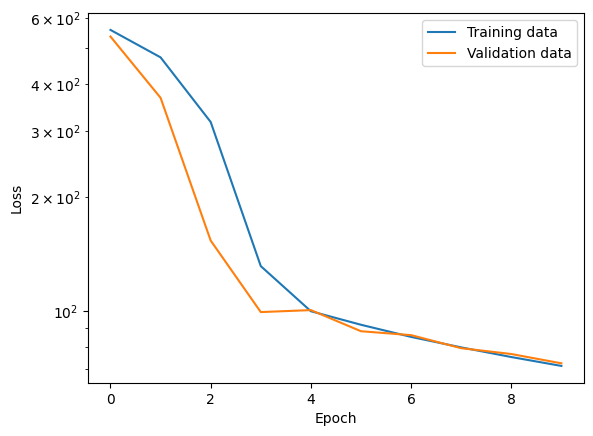

4/4 [==============================] - 0s 3ms/step


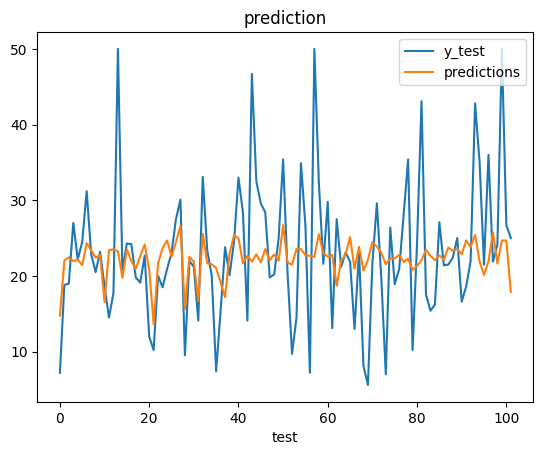

In [17]:
boston_run(10,1000,'log')

In [18]:
#if __name__== '__main__':
#  main()

In [19]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/tsp00/mass/master/mass20.csv', on_bad_lines='skip')
data = pd.read_csv('https://raw.githubusercontent.com/tsp00/mass/master/mass20.csv')

In [20]:
data.head

<bound method NDFrame.head of          0    1  N-Z    N    Z    A  EL     MASSEXCESS  dMASSEXCESS  \
0        1  0.0    1    1    0    1   n    8071.318060     0.000440   
1        2  NaN   -1    0    1    1   H    7288.971064     0.000013   
2        3  0.0    0    1    1    2   H   13135.722900     0.000015   
3        4  0.0    1    2    1    3   H   14949.810900     0.000080   
4        5  NaN   -1    1    2    3  He   14931.218880     0.000060   
...    ...  ...  ...  ...  ...  ...  ..            ...          ...   
3553  3554  NaN   59  176  117  293  Ts  194428.000000   778.000000   
3554  3555  NaN   57  175  118  293  Og  198802.000000   709.000000   
3555  3556  0.0   60  177  117  294  Ts  196397.000000   593.000000   
3556  3557  NaN   58  176  118  294  Og  199320.000000   553.000000   
3557  3558  0.0   59  177  118  295  Og  201369.000000   655.000000   

      BINDINGENERGY_A  dBINDINGENERGY_A  BETA_DECAYENERGY  dBETA_DECAYENERGY  \
0             0.00000           0.000

In [21]:
data

,0,1,N-Z,N,Z,A,EL,MASSEXCESS,dMASSEXCESS,BINDINGENERGY_A,dBINDINGENERGY_A,BETA_DECAYENERGY,dBETA_DECAYENERGY,ATOMICMASS,dATOMICMASS,IsCalculated
0,1,0.0,1,1,0,1,n,8071.318060,0.000440,0.00000,0.00000,782.34700,0.00040,1.008665e+06,0.000470,0
1,2,NaN,-1,0,1,1,H,7288.971064,0.000013,0.00000,0.00000,NaN,NaN,1.007825e+06,0.000014,0
2,3,0.0,0,1,1,2,H,13135.722900,0.000015,1112.28310,0.00020,NaN,NaN,2.014102e+06,0.000015,0
3,4,0.0,1,2,1,3,H,14949.810900,0.000080,2827.26540,0.00030,18.59202,0.00006,3.016049e+06,0.000080,0
4,5,NaN,-1,1,2,3,He,14931.218880,0.000060,2572.68044,0.00015,-13736.00000,2000.00000,3.016029e+06,0.000060,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,3554,NaN,59,176,117,293,Ts,194428.000000,778.000000,7095.00000,3.00000,-4374.00000,1053.00000,2.932087e+08,835.000000,1
3554,3555,NaN,57,175,118,293,Og,198802.000000,709.000000,7078.00000,2.00000,NaN,NaN,2.932134e+08,761.000000,1
3555,3556,0.0,60,177,117,294,Ts,196397.000000,593.000000,7092.00000,2.00000,-2923.00000,811.00000,2.942108e+08,637.000000,1
3556,3557,NaN,58,176,118,294,Og,199320.000000,553.000000,7079.00000,2.00000,NaN,NaN,2.942140e+08,594.000000,1


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3558 entries, 0 to 3557
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   0                  3558 non-null   int64  
 1   1                  295 non-null    float64
 2   N-Z                3558 non-null   int64  
 3   N                  3558 non-null   int64  
 4   Z                  3558 non-null   int64  
 5   A                  3558 non-null   int64  
 6   EL                 3558 non-null   object 
 7   MASSEXCESS         3558 non-null   float64
 8   dMASSEXCESS        3558 non-null   float64
 9   BINDINGENERGY_A    3558 non-null   float64
 10  dBINDINGENERGY_A   3558 non-null   float64
 11  BETA_DECAYENERGY   3263 non-null   float64
 12  dBETA_DECAYENERGY  3263 non-null   float64
 13  ATOMICMASS         3558 non-null   float64
 14  dATOMICMASS        3558 non-null   float64
 15  IsCalculated       3558 non-null   int64  
dtypes: float64(9), int64(6),

In [23]:
data.values[3]

array([4, 0.0, 1, 2, 1, 3, 'H', 14949.8109, 8e-05, 2827.2654, 0.0003,
       18.59202, 6e-05, 3016049.281, 8e-05, 0], dtype=object)

In [24]:
data['Z'][4]

2

In [25]:
data.shape[0]

3558

In [26]:
def dd(k, model=dz10):
  Z= data['Z'][k]
  N= data['N'][k]
  BE20= (Z+N) * data['BINDINGENERGY_A'][k]/1000
  dBE20= (Z+N) * data['dBINDINGENERGY_A'][k]/1000
  iscal= data['IsCalculated'][k] == 1
  modelval= model(Z,N)
  return (Z,N, modelval-BE20, dBE20, data['IsCalculated'][k], modelval, BE20)

m10=list()
for k in range(data.shape[0]):
  tmp= dd(k,dz10)
  m10.append(tmp)


In [27]:
def weight0(Z,N,dBE=0, isCalc=0):
  if Z>=20 and N>20 and dBE <= 0.100 and isCalc==0: return 1
  return 0

def weight1(Z,N,dBE=0, isCalc=0):
  if Z>=20 and N>20: return 1/(0.100*0.100 + (1+isCalc)*dBE*dBE)
  return 0

def weight2(Z,N,dBE=0, isCalc=0):
  if Z>=20 and N>20: return 1/(0.100*0.100 + (1+3*isCalc)*dBE*dBE)
  return 0

In [28]:
def eval_sigma(lst, weight= weight0):
   y2=0
   denorm =0
   ncount=0
   for k in range(len(lst)):
      Z, N, err, tol, iscalc, be, be_data =lst[k]
      w=weight(Z,N,tol, iscalc)
      y2 += w * err * err
      denorm += w
      if w > 0 : ncount += 1
   return np.sqrt(y2/denorm), np.sqrt(ncount/denorm), ncount, len(lst)

In [29]:
eval_sigma(m10)

(0.5598845451798965, 1.0, 2164, 3558)

In [30]:
eval_sigma(m10,weight1)

(0.6117217730025645, 0.1198697939114926, 3156, 3558)

In [31]:
eval_sigma(m10,weight2)

(0.5903129481672612, 0.12048744397818492, 3156, 3558)

In [32]:
x1=100
x2=200
x1,x2= x1+x2,x1-x2

In [33]:
x1

300

In [34]:
m33=list()
for k in range(data.shape[0]):
  tmp= dd(k,dz33)
  m33.append(tmp)

In [35]:
eval_sigma(m33,weight0)

(0.3668417817298896, 1.0, 2164, 3558)

In [36]:
eval_sigma(m33,weight1)

(0.4051446573906963, 0.1198697939114926, 3156, 3558)

In [37]:
eval_sigma(m33,weight2)

(0.3885872119832257, 0.12048744397818492, 3156, 3558)

In [38]:
dd(981,dz33)

(38, 52, -0.4335324724701195, 0.001449, 0, 782.20685452753, 782.6403870000001)

In [39]:
dz33(21,33)

451.7344323930868

In [40]:
dz10(21,33)

452.02928153844067

In [41]:
dz33_op(30,40)

array([[ 5.65548216e+01, -1.38637231e+01,  3.06422219e+00,
        -7.51156609e-01,  0.00000000e+00, -0.00000000e+00,
         9.59253276e-01, -2.35149214e-01,  1.12759733e+02,
        -2.76416701e+01,  1.37036182e+01, -3.35927448e+00,
         0.00000000e+00, -0.00000000e+00, -5.34846055e+00,
         1.31110972e+00,  9.72447372e+00, -2.38383585e+00,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -4.32978304e-01,
         1.06139338e-01,  3.13047762e+00, -7.67398319e-01,
        -1.95289722e+02, -7.00393643e-02,  2.85714286e-02],
       [ 5.65548216e+01, -1.38637231e+01,  3.06422219e+00,
        -7.51156609e-01,  0.00000000e+00, -0.00000000e+00,
         9.59253276e-01, -2.35149214e-01,  1.12759733e+02,
        -2.76416701e+01,  1.37036182e+01, -3.35927448e+00,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+

In [42]:
#_______________________________________________________________________________
# dz33 operators
def dz33_op2 (nz, nx):
   dyda= np.zeros(33)
   dyda_table= np.zeros(shape=(2,33))
   #    !C*****************************************
   #    !      data a/ 9.0914,   6.3355,   4.5791,  19.8946,   1.7325,   7.5247,
   #    !     &       -7.1953, -39.9787,  -0.3976,   0.8131,  -0.7435,  -3.7291,
   #    !     &       -0.1305,  -0.6387,   0.4534,   2.0605,   0.3449,   1.4727,
   #    !     &       -1.0433,   0.0000,   5.2495,   0.0000, -32.1007,-151.1164,
   #    !     &       -4.6103, -32.4238, -37.3226, -52.1673,   0.9597,   3.0024,
   #    !     &        0.6977,   6.0390,  17.7960/
   #    ! Data=1751 RMS= 0.330  (mars 95)
   #    !FM+*   9.09 fm+*   6.34 FS+*   4.58 fs+*  19.89 FS-*   1.73 fs-*   7.52
   #    !FC+*  -7.20 fc+* -39.98 PM+*  -0.40 pm+*   0.81 PS+*  -0.74 ps+*  -3.73
   #    !PS-*  -0.13 ps-*  -0.64 S3 *   0.45 s3 *   2.06 SQ-*   0.34 sq-*   1.47
   #    !D3 *  -1.04 d3     0.00 QQ+*   5.25 qq+    0.00  D0* -32.10  d0*-151.12
   #    !QQ-*  -4.61 qq-* -32.42  TT* -37.32  tt* -52.17  SS*   0.96  ss*   3.00
   #    ! C *   0.70 P0 *   6.04 P1 *  17.80
   #    !                    ----------------------
   #    ! 31 Coulomb
   #    ! 32+33 Pairing
   #    !
   imax = 18
   #mo = 2
   maxp = 8
   nn= np.array([nx,nz])
   v = nx + nz
   t = np.abs(nx-nz)
   r = np.power(v, 1./3.)
   #s = r*r
   rc = r*(1. - 0.25*np.power(t/v, 2))
   ra = (rc*rc)/r
   #    !******************
   for ndef in range(2): # ndef= 0->SPH# 1->DEF#
      jup= np.zeros(2)
      jud= np.zeros(2)
      #       !-----------
      ju= 4 if (ndef == 1 and nz > 50) else 0
      fyda= np.zeros(33)
      dyda= np.zeros(33)
      ss=0

      noc= np.zeros(shape=(2,imax))
      n_onp= np.zeros(shape=(2,maxp+1))
      s_onp= np.zeros(shape=(2,maxp+1))
      n_ot= np.zeros(shape=(2,maxp+1))
      s_ot= np.zeros(shape=(2,maxp+1))

      oei= np.zeros(2)
      dei= np.zeros(2)
      sshell= np.zeros(2)

      for j in range(2):
         ncum = 0
         for i1 in range(999+1):
            i = i1 + 1
            ie = i
            if (i%2 != 0):
               id = i + 1
               if (ncum < nn[j]): sshell[j] = 1	# ! !sscouche  J
            else:
               id = i*(i - 2)/4
               if (ncum < nn[j]): sshell[j] = 2	# ! ! SSC R

            ncum += id
            if (ncum > nn[j]): break
            noc[j][i1] = id

         i = ie
         ip = (i-1)//2	# ! !N0 couche HO
         moc = nn[j] - ncum + id
         if ((ndef == 1) and (i%2 != 0)):
            jup[j] = 0
            jud[j] = max(0, ju-moc)
         else:
            #jup[j] = min(ju, moc)
            jup[j] = ju
            jud[j] = 0

         noc[j][i-1] = moc - jup[j] + jud[j]
         noc[j][i] = jup[j]
         noc[j][i - 2] -= jud[j]
         oei[j] = moc + ip*(ip - 1) - ju if (i%2 != 0) else moc - ju
         dei[j] = ip*(ip + 1) + 2        if (i%2 != 0) else (ip + 1)*(ip + 2) + 2

         #          !C HERE,DEGENERACIES AND NUMBER OF ACTIVE PARTICLES  FOR  EI.
         #ipl = 0
         vmr = 0.
         vmj = 0.
         for ii in range(imax):
            onps = 0.
            ip = (ii)//2
            #degi = (ip + 1)*(ip + 2)
            fac = 1./np.sqrt((ip + 1)*(ip + 2))
            #if (ip != ipl): ipl= ipl+1
            if (2*ip == ii):
               vm2 = (0.5*ip)/(ip + 1)
               degr = ip*(ip - 1)
               if (ip > 2):
                  vmr = (0.5*(ip - 1))/ip
                  vmj = -1./ip
                  onps = noc[j][ii]*vmr if (noc[j][ii] <= degr) else degr*vmr + (noc[j][ii] - degr)*vmj

            if (2*ip != ii): vm2 = -1./(ip + 1)	# ! !SSc. j
            s_onp[j][ip] += noc[j][ii]*vm2
            n_onp[j][ip] += noc[j][ii]*fac
            ss += onps*(n_onp[j][ip] + s_onp[j][ip])

      # ! !END OF LOOP OVER FLUIDS, j
      alfa = 0 if (ndef == 1) else 0.5

      facn = np.power(dei[0], alfa)
      facz = np.power(dei[1], alfa)
      qn = oei[0]*(dei[0] - oei[0])/dei[0]*facn/np.sqrt(dei[0])
      qz = oei[1]*(dei[1] - oei[1])/dei[1]*facz/np.sqrt(dei[1])
      s3 = qn*(2*oei[0] - dei[0])*facn/np.sqrt(dei[0]) + qz*(2*oei[1] - dei[1])*facz/np.sqrt(dei[1])
      qqp = (qn + qz)*(qn + qz) + (qn - qz)*(qn - qz)
      qqm = (qn + qz)*(qn + qz) - (qn - qz)*(qn - qz)

      for i in range(maxp+1):
            n_ot[0][i] = n_onp[0][i] + n_onp[1][i]
            n_ot[1][i] = n_onp[0][i] - n_onp[1][i]
            s_ot[0][i] = s_onp[0][i] + s_onp[1][i]
            s_ot[1][i] = s_onp[0][i] - s_onp[1][i]

      #op= np.zeros(shape=(2,3,2))
      n_op= np.zeros(shape=(2))
      n_op_sqr= np.zeros(shape=(2))
      s_op= np.zeros(shape=(2))
      s_op_sqr= np.zeros(shape=(2))
      x_op= np.zeros(shape=(2))

      for i in range(maxp+1):
         fac = np.sqrt((i + 1)*(i + 2))
         for j in range(2):
               n_op[j] += n_ot[j][i]
               n_op_sqr[j] += (n_ot[j][i]**2)*fac
               s_op[j] += s_ot[j][i]
               s_op_sqr[j] += (s_ot[j][i]**2)*fac

      for j in range(2):
         op1,op2=0,0
         for i in range(maxp+1):
            fac = np.sqrt((i + 1)*(i + 2))
            op1 += n_ot[j][i]/fac
            op2 += s_ot[j][i]/fac
         x_op[j] = op1*op2

      fyda[ 0] = (n_op[0]**2 + n_op[1]**2)/2
      fyda[ 2] = s_op[0]**2 + s_op[1]**2
      fyda[ 4] = s_op[0]**2 - s_op[1]**2
      fyda[ 6] = x_op[0]    + x_op[1]
      fyda [8] = n_op_sqr[0] + n_op_sqr[1]
      fyda[10] = s_op_sqr[0] + s_op_sqr[1]
      fyda[12] = s_op_sqr[0] - s_op_sqr[1]
      fyda[26] = -t*(t + 2)/(4*r*r)
      fyda[28] = ss
      if (ndef == 0):
         fyda[14] = s3
         fyda[16] = qqm
      else:
         fyda[18] = s3
         fyda[20] = qqp
         fyda[22] = 16. - qqm
         fyda[24] = qqm

      for mss in range(0,30,2):
         dyda[mss] = fyda[mss]/ra
         dyda[mss+1] = -dyda[mss]/ra

      #       !---------
      z2 = nz*(nz - 1)
      dyda[30] = (-z2 + 0.76*np.power(z2, 2./3.))/rc	# ! !Coulomb
      #       !---------
      #rxz = 1/ra	# ! !Pairing
      for j in range(2):
         dyda[31] += -1/ra
         if (sshell[j] == 2.): dyda[32] += 1/v
         #          !        !effet de couche en 1/A
         if (nn[j]%2 == 0): dyda[31] += 1/ra - (t/v)/ra

      j = 1	# ! !  Z>N
      if (nn[0] >= nn[1]): j = 0	# ! !  N>ou=Z
      if (nn[j]%2 == 0 and nn[1-j]%2 != 0): dyda[31] += -(t/v)/ra
      #       !********
      for mss in range(33):
         dyda_table[ndef,mss] = dyda[mss]
   return dyda_table


In [43]:
dz33_op2(32,45) - dz33_op(32,45)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])